### Recommendation system

I present a small recommendation system for the Steam game store database that utilizes Feature Extraction 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

In [2]:
# Importing the files you want
steam_csv = pd.read_csv("C:/Users/steph/Desktop/Recommender/steam.csv")
descr_csv = pd.read_csv("C:/Users/steph/Desktop/Recommender/steam_description_data.csv")

C:\Users\steph\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (0,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
# Total size
steam_csv.shape

(27075, 18)

The recommendation system will be based on the game name, developer, genre, tags and description. The dataframe contains 27,000 games. Since not all games can meet their tags or players' expectations, I decided to remove games with a difference between positive and negative ratings less than 10. One of the options might not be to completely remove these games from the dataframe, but to remove these games from the recommendations, which will allow you to search games similar to them, but with a positive rating. But the first method allows you to reduce the dataframe, so I could not resist deleting. Games without English translation have been removed, as recommendations for such games are likely to be incorrect

In [4]:
# Combining dataframes
steam_csv = steam_csv.rename(columns={'appid':'steam_appid'})
united_df = steam_csv.merge(descr_csv, on='steam_appid')

# Removing unused columns
united_df = united_df.drop(['release_date',
                            'platforms',
                            'required_age',
                            'achievements',
                            'average_playtime',
                            'median_playtime',
                            'owners',
                            'price',
                            'about_the_game',
                            'categories',
                            'publisher',
                            'detailed_description'],1)

# Creating a rating difference
united_df['rating_difference'] = united_df['positive_ratings'] - united_df['negative_ratings']

# Removing games with negative and very low ratings
united_df = united_df.drop(united_df[united_df['rating_difference'] <= 10].index).reset_index(drop=True)

# Removing games without English translation
united_df = united_df.drop(united_df[united_df['english'] == 0].index).reset_index(drop=True)

In [5]:
# Total size 
united_df.shape

(12330, 204)

# Data Exploration

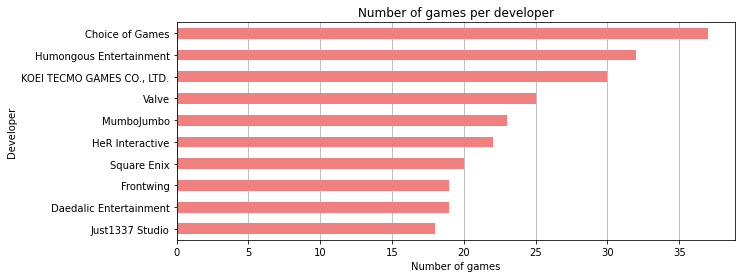

In [6]:
# Selecting the required part of the dataframe
dev_head = united_df['developer'].value_counts().head(10)

# Create a figure
fig1, ax1 = plt.subplots(figsize=(10,4))

# Building a graph from a series
dev_head.plot(kind='barh', color='lightcoral', ax=ax1)

# Changing the order of lines on the chart
plt.gca().invert_yaxis()

# Sign the axes and give the name
plt.title('Number of games per developer')
plt.xlabel('Number of games')
plt.ylabel('Developer')

# Draw vertical lines
plt.grid(axis='x')
ax1.set_axisbelow(True)
plt.show()

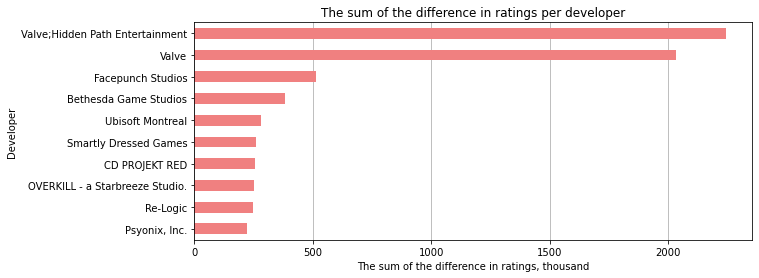

In [7]:
# Selecting the required part of the dataframe
group_sum = united_df.groupby('developer')['rating_difference'].sum()

# Divide values to improve display
head_mill = group_sum.sort_values(ascending=False).head(10)/1000

fig2, ax2 = plt.subplots(figsize=(10,4))

head_mill.plot(kind='barh', color='lightcoral', ax=ax2)

plt.gca().invert_yaxis()

plt.title('The sum of the difference in ratings per developer')
plt.xlabel('The sum of the difference in ratings, thousand')
plt.ylabel('Developer')

plt.grid(axis='x')
ax2.set_axisbelow(True)
plt.show()

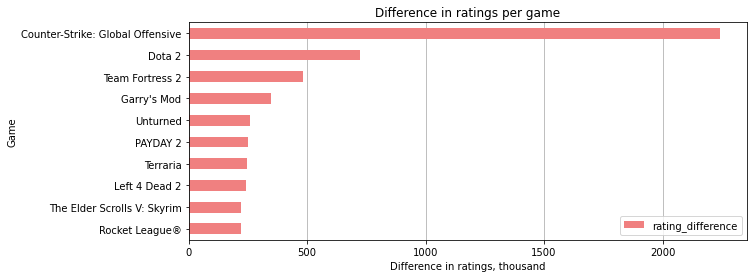

In [8]:
# Repeat all the same
diff_sort = united_df.sort_values(by='rating_difference', ascending=False).head(10)
diff_sort['rating_difference'] = diff_sort['rating_difference']/1000

fig3, ax3 = plt.subplots(figsize=(10,4))

diff_sort.plot(kind='barh', y='rating_difference', x='name', color='lightcoral', ax=ax3)

plt.gca().invert_yaxis()

plt.title('Difference in ratings per game')
plt.xlabel('Difference in ratings, thousand')
plt.ylabel('Game')

plt.grid(axis='x')
ax3.set_axisbelow(True)
plt.show()

# Combining data for analysis

In [9]:
# Separating tags with a space
def globalization(strok:str):
    return strok.replace(';', ' ')

# Removing duplicate tags
def del_rep(strok:str):
    spl_strok = strok.split()
    return ' '.join(sorted(set(spl_strok), key=spl_strok.index))

# Converting to lower case
def to_low(strok:str):
    return strok.lower()

I had to combine the values from the columns name, developer, genres, steamspy_tags into one. All letters are converted to lower case. Sometimes the values of the genres and steamspy_tags columns are the same, so you need to remove duplicates

In [10]:
# Separating tags with a space
united_df['genres'] = united_df['genres'].apply(globalization)
united_df['steamspy_tags'] = united_df['steamspy_tags'].apply(globalization)

# Combining genres and tags
united_df['genres&tags'] = united_df['genres'] + ' ' + united_df['steamspy_tags']

# Removing duplicate tags
united_df['genres&tags'] = united_df['genres&tags'].apply(del_rep)

# Convert strings to lowercase and concatenate into one column
cols = ['developer', 'genres&tags']
united_df['alls'] = united_df['name'].copy().apply(to_low)
for i in cols:
  united_df['alls'] += ' ' + united_df[i].apply(to_low)

In [11]:
# How it looks
united_df['alls']

0              counter-strike valve action fps multiplayer
1        team fortress classic valve action fps multipl...
2        day of defeat valve action fps world war ii mu...
3          deathmatch classic valve action fps multiplayer
4        half-life: opposing force gearbox software act...
                               ...                        
12325    a legionary's life alessandro roberti indie rp...
12326    the underground watcher/地下监察员 yima vlg. action...
12327      the renovator mirzagame5 indie horror adventure
12328                 blacksmith run skull box games indie
12329    captainmarlene dnovel adventure indie early ac...
Name: alls, Length: 12330, dtype: object

By calculating the cosine similarity for each game, we can determine how similar they are.

In [12]:
# Convert a collection of text documents to a matrix of token counts
count_vec = CountVectorizer(stop_words='english')
count_matrix = count_vec.fit_transform(united_df['alls'])

# Compute cosine similarity
cosine_sim = cosine_similarity(count_matrix, count_matrix)

Converting short description to vectors. For text-like strings, it is better to use the TfidfVectorizer. He performs the TF-IDF transformation from a provided matrix of counts. Using hstack, you can combine matrices and calculate the cosine convergence so that when making recommendations, you can also take into account the description of the game

In [13]:
# Convert a collection of raw documents to a matrix of TF-IDF features
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(united_df['short_description'])

# Stack sparse matrices horizontally
st = hstack([count_matrix, tfidf_matrix])

# Compute cosine similarity
cosine_sim2 = cosine_similarity(st, st)

This function makes 10 recommendations based on the calculated cosine similarity. In this case, there are two options: recommendations based on title, developer and tags, and the same recommendations, but using a short description

In [14]:
# The main function that makes recommendations
def get_rec(nam:str, cosine):
#     Determine the index
    ind = united_df[united_df['name'] == nam].index.to_list()[0]
    
#     Obtaining cosine convergence by index
    cos_scor = list(enumerate(cosine[ind]))
    
#     Getting the most suitable games
    cos_scor = sorted(cos_scor, key=lambda x: x[1], reverse=True)
    cos_scor = cos_scor[1:11]
    ten_ind = [i[0] for i in cos_scor]
    return united_df['name'].iloc[ten_ind]

# Examples and use case

Below are some examples of recommended games. In general, the two versions of recommendations are not critically different and their recommendations are approximately the same. For games that are part of a large franchise, the recommendations may not differ at all (example 2). But the second option, which takes into account the description of the games, may recommend games that are not quite suitable by genre, but suitable by topic.

# Example 1

In [15]:
# Example 1
naz = "S.T.A.L.K.E.R.: Shadow of Chernobyl"
print('Recommendation for', naz, '\n')
print('Recommendations using game name, developer, genre and tags \n')
print(get_rec(naz, cosine_sim),'\n')
print(print('Recommendations using game name, developer, genre, tags and description \n'))
print(get_rec(naz, cosine_sim2))

Recommendation for S.T.A.L.K.E.R.: Shadow of Chernobyl 

Recommendations using game name, developer, genre and tags 

655                       S.T.A.L.K.E.R.: Call of Pripyat
378                             S.T.A.L.K.E.R.: Clear Sky
410                                             Fallout 3
4512                                            Fallout 4
415                   Fallout 3: Game of the Year Edition
797                                              Gothic 1
416                                    Fallout: New Vegas
2301                   Hard Truck Apocalypse / Ex Machina
1272    Sea Dogs: To Each His Own - Pirate Open World RPG
9335                                         Fallout 4 VR
Name: name, dtype: object 

Recommendations using game name, developer, genre, tags and description 

None
655                       S.T.A.L.K.E.R.: Call of Pripyat
378                             S.T.A.L.K.E.R.: Clear Sky
410                                             Fallout 3
4512                 

# Example 2

In [16]:
# Example 2
naz = "Call of Duty® 4: Modern Warfare®"
print('Recommendation for', naz, '\n')
print('Recommendations using game name, developer, genre and tags \n')
print(get_rec(naz, cosine_sim),'\n')
print(print('Recommendations using game name, developer, genre, tags and description \n'))
print(get_rec(naz, cosine_sim2))

Recommendation for Call of Duty® 4: Modern Warfare® 

Recommendations using game name, developer, genre and tags 

234              Call of Duty®: Modern Warfare® 2
66                                Call of Duty® 2
1096                        Call of Duty®: Ghosts
4907    Call of Duty®: Modern Warfare® Remastered
65                                  Call of Duty®
2843                 Call of Duty®: Black Ops III
1165        Call of Duty: Black Ops - Mac Edition
988                   Call of Duty®: Black Ops II
731                                 Borderlands 2
5                                        Ricochet
Name: name, dtype: object 

Recommendations using game name, developer, genre, tags and description 

None
234              Call of Duty®: Modern Warfare® 2
66                                Call of Duty® 2
1096                        Call of Duty®: Ghosts
4907    Call of Duty®: Modern Warfare® Remastered
65                                  Call of Duty®
2843                 Call of

# Example 3

In [17]:
# Example 3
naz = "Tropico 5"
print('Recommendation for', naz, '\n')
print('Recommendations using game name, developer, genre and tags \n')
print(get_rec(naz, cosine_sim),'\n')
print(print('Recommendations using game name, developer, genre, tags and description \n'))
print(get_rec(naz, cosine_sim2))

Recommendation for Tropico 5 

Recommendations using game name, developer, genre and tags 

429                         Tropico 3
756                         Tropico 4
427                  Grand Ages: Rome
6594                   Surviving Mars
425     Imperium Romanum Gold Edition
7615                        Caesar™ 3
8776                      Constructor
1080       Omerta - City of Gangsters
7065                        Tropico 6
8481              Pharaoh + Cleopatra
Name: name, dtype: object 

Recommendations using game name, developer, genre, tags and description 

None
756                         Tropico 4
429                         Tropico 3
427                  Grand Ages: Rome
6594                   Surviving Mars
425     Imperium Romanum Gold Edition
7615                        Caesar™ 3
7065                        Tropico 6
539                  Tropico Reloaded
8481              Pharaoh + Cleopatra
1080       Omerta - City of Gangsters
Name: name, dtype: object
